# Reservoir Re-operation Example

This notebook demonstrates hard-coupling power-water systems using the `PowerWaterCoupler` class. Without coupling, the power system dispatches hydropower based on a predetermined water release schedule from the water system. This arrangement leads to inefficiencies owing to (1) periods when the water system releases too much water, leading to hydropower curtailment and (2) periods when the water system might not release enough, leaving potential hydropower generation untapped. In contrast, model coupling improves efficient use of hydropower by allowing the power and water systems to communicate. In the current implementation, model coupling encourages the power system to maximize water use at each time step as hydropower is generally a cheaper electricity source. 

This example follows the code shown in the "Custom Workflow Example". Additional steps involved calling `ReservoirManager` and `PowerWaterCoupler` classes. Outputs from the regular model and the re-operation model are also compared.

In this example, we simulate the reservoir re-operation over one simulation year (365 days). The power system model, named "hydro_system", includes two nodes connected by a trasmission line. Node1 has two hydropower units ("Atay" and "Kamchay") and one thermal unit. The two hydropower units are located on a river cascade. Node 2 has one hydropower unit ("Kirirom") and one thermal unit. Data files for this case study, called "hydro_system", can be found [here](https://github.com/Critical-Infrastructure-Systems-Lab/PowNet/tree/master/model_library). Please download them to a folder on your local machine.

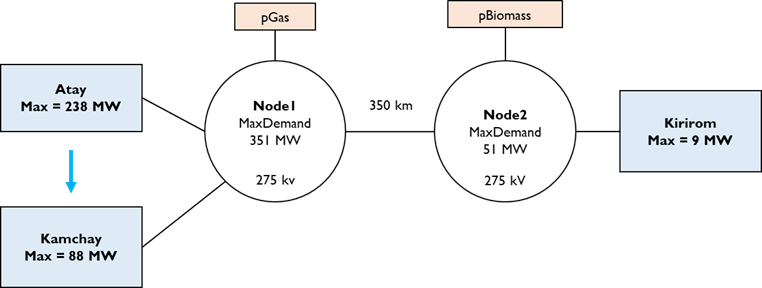

In [1]:
import os
from IPython.display import Image, display
from pownet.folder_utils import get_pownet_dir

project_root = get_pownet_dir()
image_path = os.path.join(project_root, "images", "hydro_system.png")
display(Image(filename=image_path))

## Setup: Input/Output Folders and Simulation Parameters

First, we specify the directory containing the input data for the power system model using `input_folder`. Inside, there is also a sub-folder called `reservoir_data` containing information on the characteristics of reservoirs, along with their inflows and minimum environmental flows. If simulation results need to be saved, we also define the `output_folder`. 

Next, we set key simulation parameters:

* `model_name`: The identifier for the power system case ("solar_ess")
* `model_year`: The year for which the simulation data belongs
* `sim_horizon`: The duration of each individual optimization run, typically representing the day-ahead market horizon (24 hours)
* `steps_to_run`: The total number of sequential simulation runs to execute (running the 24-hour simulation 3 times for 3 consecutive days)
* `solver`: The mathematical optimization solver

In [2]:
from pownet import (
    DataProcessor,       # For processing raw input data
    SystemInput,         # For loading and validating model inputs
    ModelBuilder,        # For constructing the optimization model
    SystemRecord,        # For storing simulation results
    OutputProcessor,     # For post-processing results
    Visualizer,          # For plotting results
)

from pownet.coupler import PowerWaterCoupler # Coupling power and water systems
from pownet.reservoir import ReservoirManager # Reservoir modeling

# Import utility for creating initial conditions
from pownet.data_utils import create_init_condition


# Define input and output directories relative to the project root.
# Note: Adjust these paths if you installed PowNet via pip and your data is elsewhere.
input_folder = os.path.join(project_root, "model_library")
output_folder = os.path.join(project_root, "outputs")

# Define the specific model name and year
model_name = "hydro_system"
model_year = 2016

# Simulation parameters
sim_horizon = 24  # Simulation horizon in hours
steps_to_run = 365  # Number of simulation days (3 * 24 hours = 72 hours total)
solver = "gurobi"  # Specify the optimization solver ('gurobi' or 'highs')

## Estimate daily hydropower availability with the Reservoir module

The reservoir module uses simple mass-balance equations to estimate the hourly hydropower availability. The `ReservoirManager` class streamlines the simulation of reservoirs in the system. Because reservoirs can be located in a cascade, the `ReservoirManager` class begins its simulation from the most upstream reservoir. 

The `ReservoirManager` clase requires the following CSV files, located in the `reservoir_data` folder. 
- flow_path.csv: contains reservoir connectivity
- inflow.csv: contains daily inflows to reservoirs
- minimum_flow.csv: contains daily minimum environmental flows of each reservoir
- reservoir_unit.csv: contains reservoir parameters

In [3]:
reservoir_manager = ReservoirManager()
# Specify the path to the input data here
reservoir_manager.load_reservoirs_from_csv(
    os.path.join(input_folder, model_name, "reservoir_data")
)
reservoir_manager.simulate()

Set parameter Username
Set parameter LicenseID to value 2593676
Academic license - for non-commercial use only - expires 2025-12-01


After simulation, we get time series of daily hydropower availability, which we can use to create `hydropower_daily.csv` for the `SystemInput` class.

In [4]:
daily_hydropower_df = reservoir_manager.get_hydropower_ts()
daily_hydropower_df.head()

,kirirom,atay,kamchay
1,25.884505,752.142209,451.383843
2,118.756400,1804.496919,1306.520294
3,118.430737,1795.656521,1293.184299
4,118.106700,1787.537591,1284.292211
5,117.784604,1779.333897,1273.464923


In this example, "hydropower_daily.csv" has already been created. Therefore, we are not creating a CSV file with `daily_hydropower_df`.

## Data Preprocessing

PowNet requires certain preprocessed data files in addition to user-provided inputs. The `DataProcessor` class automatically generates these necessary files if they don't exist. These files, prefixed with `pownet_`, contain information like derated capacities (for transmission lines, thermal units, storage units) and basic cycles in the network. They are saved within the model's input folder.

If the underlying system parameters (capacities, network topology) remain unchanged, these `pownet_` files only need to be generated once. This improves computational efficiency, especially during sensitivity analyses or when exploring uncertainties like renewable energy variability, as preprocessing is skipped on subsequent runs.

In [5]:
data_processor = DataProcessor(
    input_folder=input_folder, model_name=model_name, year=2016, frequency=50
)
data_processor.execute_data_pipeline()

## Loading System Inputs

The `SystemInput` class is responsible for reading all the model input CSV files (both user-provided and auto-generated) and performing data validation checks to ensure correct formatting and consistency. 

This example uses the spinning reserve factor of zero. Spinning reserve is provided by online thermal units. By removing spinning reserve requirement, the system can operate on 100% hydropower when available. This helps to demonstrate the impact of reservoir re-operation.

In [6]:
# Initialize SystemInput with paths, model details, simulation horizon, and penalty factors
inputs = SystemInput(
    input_folder=input_folder,
    model_name=model_name,
    year=model_year,
    sim_horizon=sim_horizon,
    spin_reserve_factor=0.0, # No spinning reserve requirement
)
# Load and validate the input data from CSV files
inputs.load_and_check_data()




PowNet Input Data Summary:
        Timestamp                 = 20250514_2316
        Model name                = hydro_system
        Year                      = 2016
        ---- System characteristics ----
        No. of nodes              = 2
        No. of edges              = 1
        No. of thermal units      = 2
        No. of demand nodes       = 2
        Peak demand               = 402 MW

        ---- Renewable capacities ----
        Hydropower units          = 0
        Daily hydropower units    = 3
        Solar units               = 0
        Wind units                = 0
        Import units              = 0

        ---- Energy storage ----
        No. of hydropower with ESS = 0
        No. of daily hydropower with ESS = 0
        No. of Solar with ESS     = 0
        No. of Wind with ESS      = 0
        No. of Thermal units with ESS = 0
        No. of Grid ESS           = 0

        ---- Modeling parameters ----
        Simulation horizon        = 24 hours
      

## Initial Conditions

For the very first simulation step (day 1, hour 0), we need to define the initial state of components that have time-coupling constraints. The `create_init_condition` utility function generates a dictionary representing a "cold start" state: thermal units are initially offline. Users can also manually create this dictionary, ensuring it follows the required format, to specify different starting conditions.

In this example, we initialize two sets of initial conditions: one for the regular model and the other one for the re-operation model.

In [7]:
# Regular model
init_conditions = create_init_condition(inputs.thermal_units)

# Re-operation model
init_conditions_reop = create_init_condition(inputs.thermal_units)

## Model Building and Simulation Setup

With the inputs loaded and initial conditions defined, we instantiate the core classes needed for running the simulation loop:

* `ModelBuilder`: Takes the `SystemInput` object and is responsible for constructing the optimization problem (variables, constraints, objective function) for each time step.
* `SystemRecord`: Takes the `SystemInput` object and is used to store the results (variable values, objective value, runtime) from each simulation step.

For the remainder of this example, we will first simulate a regular power system operation, after which we will simulate a coupled power-water system operation.

## Regular model

In the regular model, the power system only dispatches hydropower according to the predetermined availability.

In [8]:
# Initialize necessary components
model_builder = ModelBuilder(inputs)
record = SystemRecord(inputs)

for step_k in range(1, steps_to_run+1):
    # Create a new model at the first timestep
    if step_k == 1:
        power_system_model = model_builder.build(
            step_k=step_k,
            init_conds=init_conditions,
        )
    # Modify the previous model instance at subsequent timesteps
    else:
        power_system_model = model_builder.update(
            step_k=step_k,
            init_conds=init_conditions,
        )

    power_system_model.optimize(mipgap=0.001, log_to_console=False)

    # IMPORTANT: Raise an error if the model is not feasible
    if not power_system_model.check_feasible():
        raise ValueError("Model is not feasible.")

    # Store the model outputs
    record.keep(
        runtime=power_system_model.get_runtime(),
        objval=power_system_model.get_objval(),
        solution=power_system_model.get_solution(),
        step_k=step_k,
    )

    # Update the initial conditions for the next timestep
    init_conditions = record.get_init_conds()

Set parameter LogToConsole to value 0


## Re-operation model

In the coupled power-water system simulation, the power system directs reservoirs to adjust water release to match hydropower generation needed to serve electricity demand.

In [9]:
# With components for re-operation
model_builder_reop = ModelBuilder(inputs)
record_reop = SystemRecord(inputs)
model_coupler = PowerWaterCoupler(
    model_builder=model_builder_reop,
    reservoir_manager=reservoir_manager,
    solver=solver,
)

In [10]:
for step_k in range(1, steps_to_run+1):
    if step_k == 1:
        power_system_model_reop = model_builder_reop.build(
            step_k=step_k,
            init_conds=init_conditions,
        )
    else:
        power_system_model_reop = model_builder_reop.update(
            step_k=step_k,
            init_conds=init_conditions,
        )

    power_system_model_reop.optimize(mipgap=0.001, log_to_console=False)

    if not power_system_model_reop.check_feasible():
        raise ValueError("Reop model is not feasible.")
    
    #############################################################
    # Re-operate reservoirs
    # Currently, only works with daily hydropower formulation
    #############################################################

    model_coupler.reoperate(step_k=step_k)

    #############################################################

    record_reop.keep(
        runtime=power_system_model_reop.get_runtime(),
        objval=power_system_model_reop.get_objval(),
        solution=power_system_model_reop.get_solution(),
        step_k=step_k,
    )
    init_conditions = record.get_init_conds()

Set parameter LogToConsole to value 0


## Post-processing Results

Once the simulation loop completes, the `SystemRecord` object holds all the simulation results. The `OutputProcessor` class helps aggregate and transform these raw results into more convenient formats. For instance, it can process the nodal variable results -- stored as hourly time series -- into different resolutions (daily, monthly).

In [11]:
output_processor = OutputProcessor()
output_processor.load(inputs)
daily_demand = output_processor.get_daily_demand(inputs.demand)

In [12]:
# Regular model
node_variables = record.get_node_variables()
daily_generation = output_processor.get_daily_generation(node_variables)
daily_generation.round(0).head(10)

fuel_type,gas,hydropower,biomass,shortfall,curtailment
Day,,,,,
1,5530.0,1229.0,0.0,0.0,0.0
2,2854.0,3230.0,0.0,0.0,0.0
3,2876.0,3207.0,0.0,0.0,0.0
4,3569.0,3190.0,0.0,0.0,0.0
5,3589.0,3171.0,0.0,0.0,0.0
6,3606.0,3153.0,0.0,0.0,0.0
7,3620.0,3139.0,0.0,0.0,0.0
8,3577.0,3182.0,0.0,0.0,0.0
9,2860.0,3224.0,0.0,0.0,0.0


In [13]:
# Re-operation model
node_variables_reop = record_reop.get_node_variables()
daily_generation_reop = output_processor.get_daily_generation(node_variables_reop)
daily_generation_reop.round(0).head(10)

fuel_type,gas,hydropower,biomass,shortfall,curtailment
Day,,,,,
1,5530.0,1229.0,0.0,0.0,0.0
2,3229.0,2855.0,0.0,0.0,0.0
3,1911.0,4172.0,0.0,0.0,0.0
4,1311.0,5444.0,4.0,0.0,0.0
5,2620.0,4139.0,0.0,0.0,0.0
6,1360.0,5400.0,0.0,0.0,0.0
7,2653.0,4106.0,0.0,0.0,0.0
8,1404.0,5355.0,0.0,0.0,0.0
9,2010.0,4074.0,0.0,0.0,0.0


## Visualization

The `Visualizer` class offers various plotting functions to help analyze the simulation results. For example, `plot_fuelmix_area` creates a chart showing the daily energy contribution from different sources (generation types, storage discharge) compared to the daily demand.

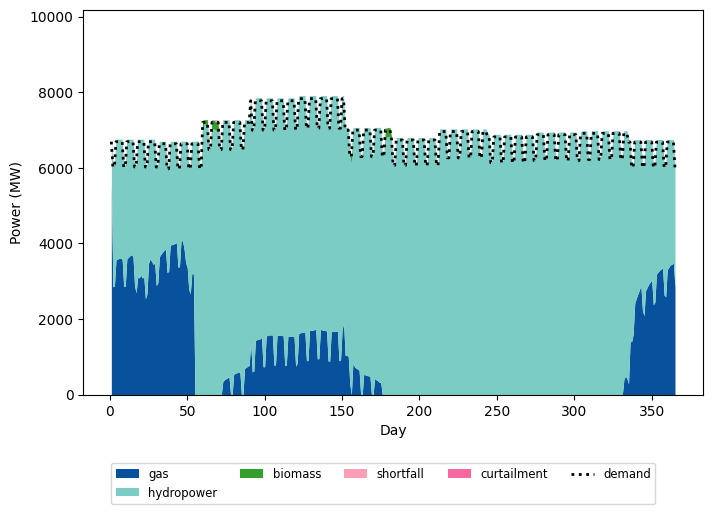

In [14]:
# Regular model
visualizer = Visualizer(inputs.model_id)
visualizer.plot_fuelmix_area(dispatch=daily_generation, demand=daily_demand)

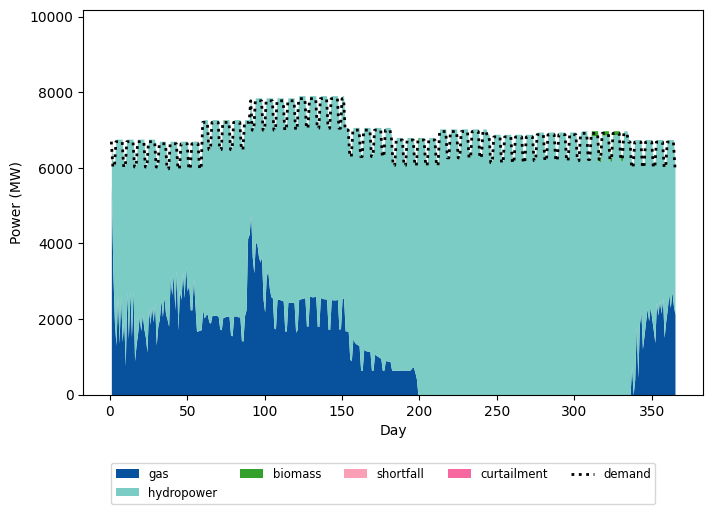

In [15]:
# Re-operation model
visualizer.plot_fuelmix_area(dispatch=daily_generation_reop, demand=daily_demand)

### Visualizing water storage levels

The re-operation model allows the power system to become aware of water availability. It can increases water release for hydropower generation, constrained by inflow and hydropeaking limits. As a result, the water storage level depletes more rapidly compared to the regular model.

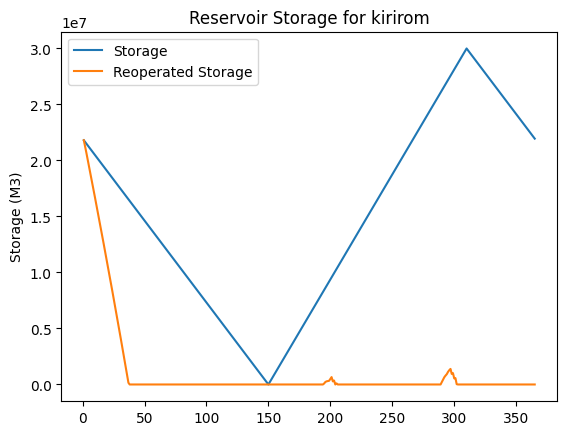

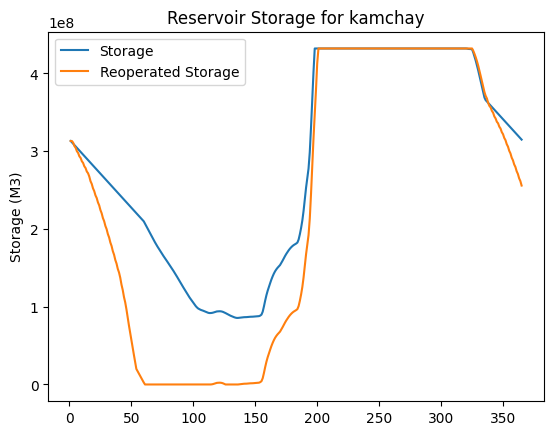

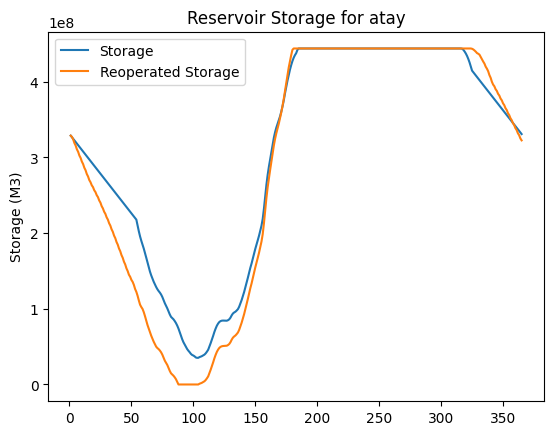

In [17]:
import matplotlib.pyplot as plt
for unit_name, reservoir in reservoir_manager.reservoirs.items():
    fig, ax = plt.subplots()
    ax.plot(reservoir.storage, label="Storage")
    ax.plot(reservoir.reop_storage, label="Reoperated Storage")

    ax.set_title(f"Reservoir Storage for {unit_name}")
    ax.set_ylabel("Storage (M3)")
    ax.legend()
    plt.show()

## Conclusion

This tutorial has demonstrated how to implement reservoir re-operation in PowNet. PowNet offers a convenient API to model these complex interactions, automatically handling intricate river topologies and reservoir dynamics. By coupling power and water systems, se can achieve more efficient hydropower dispatch and gain deeper insights, especially in systems with high solar and wind potential.